# SINVAD Experiments - Research Question 4 (Differential Testing)

This notebook provides outlines on experiments performed for RQ4 (Section 5.5 of paper). It contains code that generates results similar to those presented in Figure 14 of the paper.

## Step 0. Preparation

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sa.model import MobileNet, VGGNet, CifarClassifier
from vae.model import ConvVAE

In [2]:
# MNIST settings
# img_size = (1, 28, 28)
# h_size = 1600
# z_size = 400
# CIFAR/SVHN settings
img_size = (3, 32, 32)
h_size = 4000
z_size = 800

torch.no_grad() # since nothing is trained here

In [3]:
vae = ConvVAE(img_size = img_size[1:], c_num=img_size[0], h_dim = h_size, z_dim = z_size)
vae.load_state_dict(torch.load('./vae/models/SVHN_ConvEnD.pth'))
vae.eval()
vae.cuda()

net1 = CifarClassifier()
net1.load_state_dict(torch.load('./sa/models/SVHN_customnet.pth'))
net1.eval()
net1.cuda()

net2 = VGGNet()
net2.load_state_dict(torch.load('./sa/models/SVHN_vggnet.pth'))
net2.eval()
net2.cuda()

net3 = MobileNet()
net3.load_state_dict(torch.load('./sa/models/SVHN_mobilenet.pth'))
net3.eval()
net3.cuda()

print("models loaded")

models loaded


In [4]:
test_dataset = torchvision.datasets.SVHN(root='./data', split='test', transform=transforms.ToTensor(), download=True)
test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
print("Data loader ready")

Using downloaded and verified file: ./data/test_32x32.mat
Data loader ready


## Step 1. GA of VAE latents
Objectives:
1. make class label not label of sampled image
2. get as close as possible to sampled image latent

In [5]:
def get_nl_label(img):
    label_names = 'zero one two three four five six seven eight nine'.split()
    if img_size[0] == 1:
        img = img.view(1, 1, 28, 28)
    return 'Classified as: %s' % (label_names[net1(img).argmax().item()])

def print_odds(logits):
    probs = nn.Softmax(dim=1)(logits)
    prob_strs = ['%.3f' % p for p in probs[0]]
    return ' '.join(prob_strs)

def comp_classifiers(img, c1, c2):
    softmax_f = nn.Softmax(dim=1)
    org_logits = c1(img)
    aux_logits = c2(img)
    print('org classifier ps:', print_odds(org_logits))
    print('aux classifier ps:', print_odds(aux_logits))
    print('diff', torch.sum(torch.abs(softmax_f(org_logits) - softmax_f(aux_logits))).detach().item())

def get_show_img(tensor_img):
    if img_size[0] == 1:
        return tensor_img[0][0].cpu().numpy()
    else:
        tensor_img = tensor_img.cpu().numpy()[0]
        tensor_img = np.transpose(tensor_img, (1, 2, 0))
        return tensor_img

In [6]:
counter = 0

Actual Label: 5
Classified as: five
org classifier ps: 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000
aux classifier ps: 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000
diff 7.760399967082776e-07


(-0.5, 31.5, 31.5, -0.5)

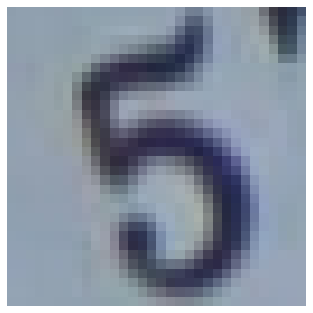

In [7]:
# Original image
for i, (x, x_class) in enumerate(test_data_loader):
    samp_img = x[0:1]
    samp_class = x_class[0].item()
    break
print('Actual Label: %s' % samp_class) 
print(get_nl_label(samp_img.cuda()))

show_img = get_show_img(samp_img)
plt.imshow(show_img)

comp_classifiers(samp_img.cuda(), net1, net2)
plt.axis('off')

In [8]:
if img_size[0] == 1:
    samp_img = samp_img.view(-1, 28*28)
img_enc, _ = vae.encode(samp_img.cuda())

Classified as: five
org classifier ps: 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000
aux classifier ps: 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000
diff 9.332396757599781e-07


(-0.5, 31.5, 31.5, -0.5)

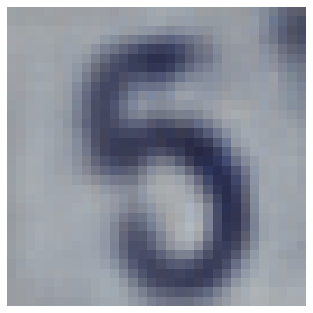

In [9]:
# VAE-reconstructed image
rec_img = vae.decode(img_enc)
if img_size[0] == 1:
    rec_img = rec_img.view(1, 1, 28, 28)
    
show_img = get_show_img(rec_img.detach())
plt.imshow(show_img)

print(get_nl_label(rec_img))

comp_classifiers(rec_img, net1, net2)
plt.axis('off')

In [10]:
# GA parameters
gen_num = 5000
pop_size = 50
init_pop = [img_enc + 1.2 * torch.randn(1, z_size).cuda() for _ in range(pop_size)]
best_left = 20
mut_size = 0.1
# mutation operator adding random noise
# crossover operator splicing

In [11]:
# GA optimization
now_pop = init_pop
prev_best = 999
binom_sampler = torch.distributions.binomial.Binomial(probs=0.2*torch.ones(img_enc.size()))
softmax = nn.Softmax(dim=1)

for g_idx in range(gen_num):
    indv_score = [999 for _ in range(pop_size)]
    for i_idx, indiv in enumerate(now_pop):
        dec_img = vae.decode(indiv)
        if img_size[0] == 1:
            dec_img = dec_img.view(1, 1, 28, 28)
        odds1 = softmax(net1(dec_img)) # customnet
        odds2 = softmax(net2(dec_img)) # vgg
        # odds3 = softmax(net3(dec_img)) # mobilenet
        if odds1[(0, samp_class)] > 0.5:
            continue
        else:
            indv_score[i_idx] = torch.sum(torch.abs(indiv - img_enc))
            indv_score[i_idx] *= (2 + odds1[(0, samp_class)] - odds2[0, samp_class])
    
    best_idxs = sorted(range(len(indv_score)), key=lambda i: indv_score[i], reverse=True)[-best_left:]
    now_best = min(indv_score)
    if abs(now_best - prev_best) < 1e-3:
        mut_size *= 0.5
    else:
        mut_size = 0.1
    parent_pop = [now_pop[idx] for idx in best_idxs]
    k_pop = []
    for k_idx in range(pop_size-best_left):
        mom_idx, pop_idx = np.random.choice(best_left, size=2, replace=False)
        spl_idx = np.random.choice(z_size, size=1)[0]
        k_gene = torch.cat([parent_pop[mom_idx][:, :spl_idx], parent_pop[pop_idx][:, spl_idx:]], dim=1) # crossover
        
        # mutation
        diffs = (k_gene != img_enc).float()
        k_gene += mut_size * torch.randn(k_gene.size()).cuda() * diffs # random adding noise only to diff places
        # random matching to img_enc
        interp_mask = binom_sampler.sample().cuda()
        k_gene = interp_mask * img_enc + (1 - interp_mask) * k_gene
        
        k_pop.append(k_gene)
    now_pop = parent_pop + k_pop
    prev_best = now_best
    print('\r                        \r', end='')
    print('%d: %.1f (%.3f)' % (g_idx, now_best.item(), mut_size), end='')
    if mut_size < 1e-3:
        break

43: 1.6 (0.001)         

In [12]:
mod_best = parent_pop[-1].clone()
prev_best = mod_best.clone() # for save
print('L1 distance from original representation:', torch.sum(torch.abs(prev_best - img_enc)).item())

L1 distance from original representation: 1.0987989902496338


In [13]:
print('# of dims that differ:', torch.sum((prev_best - img_enc) != 0).item())

# of dims that differ: 1


Classified as: six
org classifier ps: 0.000 0.000 0.000 0.000 0.000 0.467 0.533 0.000 0.000 0.000
aux classifier ps: 0.000 0.000 0.000 0.000 0.000 0.968 0.032 0.000 0.000 0.000
diff 1.0008779764175415


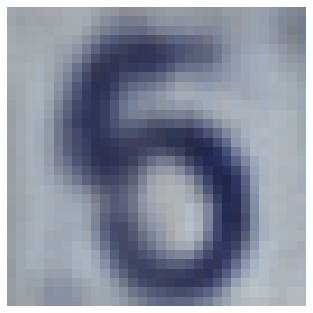

In [14]:
# Show GA-optimized image
vae_rand_imgs = vae.decode(parent_pop[-1])
if img_size[0] == 1:
    vae_rand_imgs = vae_rand_imgs.view(1, 1, 28, 28)
    
show_img = get_show_img(vae_rand_imgs.detach())
plt.imshow(show_img)


print(get_nl_label(vae_rand_imgs))
print_odds(net1(vae_rand_imgs))

plt.axis('off')

comp_classifiers(vae_rand_imgs, net1, net2)

torch.Size([1, 3, 32, 32])
Classified as: five
org classifier ps: 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000
aux classifier ps: 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000
diff 2.78864517895272e-05


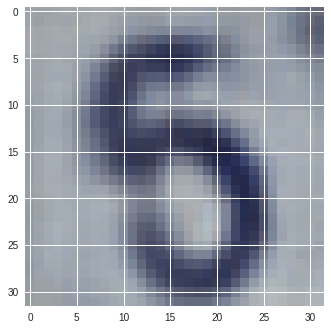

In [15]:
mid_img = vae.decode(0.5*img_enc + 0.5*prev_best)
if img_size[0] == 1:
    mid_img = mid_img.view(1, 1, 28, 28)
print(mid_img.size())
show_img = get_show_img(mid_img.detach())
plt.imshow(show_img)
print(get_nl_label(mid_img))

comp_classifiers(mid_img, net1, net2)